In [1]:
# Init
#mystock = 'sgen'
minmax_period = 25

# Load Data and set options
import stockdatalib as sd
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict 
from datetime import datetime
from IPython.core.display import display, HTML
from IPython.display import Javascript
import ipywidgets as widgets
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)
# files: screener_results.csv, constituents_csv.csv
stock_count, stock_fields, sp_df = sd.init_stocks_data('./data/','sp_const.csv')
mystock = sp_df['Symbol'][0]
sd.set_stock(mystock)
#display(sp_df)

# Read recommendation file
#recomm_df = pd.read_csv("./logs/stock_recommendations_latest.csv")
recomm_df = sp_df

l1 = recomm_df['Symbol'].to_list()
l2 = recomm_df['Name'].to_list()
l3 = recomm_df['Sector'].to_list()
l = []
for i in range(len(l1)):
    l.append(l1[i]+'-'+l2[i]+' ('+l3[i]+')')
l_all = []
for line, stuck in zip(l, l1):
    l_all.append((line,stuck))
    
w = widgets.Dropdown(
    options=l_all,
    value=l1[0],
    description='Stock:',
)

In [2]:
# Enter stock
global mystock
mystock = recomm_df['Symbol'][0]
def on_change(change):
    global mystock
    if change['type'] == 'change' and change['name'] == 'value':
        mystock = change['new']
        display(Javascript('IPython.notebook.execute_cells([2,3,4,5,6,7,8,9,10,11,12,13,14,15])'))

w.observe(on_change)
display(w)

Dropdown(description='Stock:', options=(('A-Agilent Technologies Inc (Health Care)', 'A'), ('AAL-American Airl…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [222]:
# Get stock company information
#print(sp_df["Symbol"][0])
stock_info = sd.get_stock_info(mystock)
company_name = stock_info['name'][0]
company_sector = stock_info['sector'][0]
display(HTML("<h1>"+mystock+": "+company_name+" ("+company_sector+")" + "</h1>"))
#f,s = sd.FindColumn('Profit margin')
#f

,symbol,Date,No. of Shares,Revenue,Earning before Tax,PE Ratio,Earning per Share,Net Income,Free Cash Flow Margin,Gross Profit,Free Cash Flow per Share
0,MRK,2020-03-31,2.533000e+09,1.205700e+10,3.838000e+09,62.431879,1.27,3.219000e+09,-0.02314,8.745000e+09,-0.110146


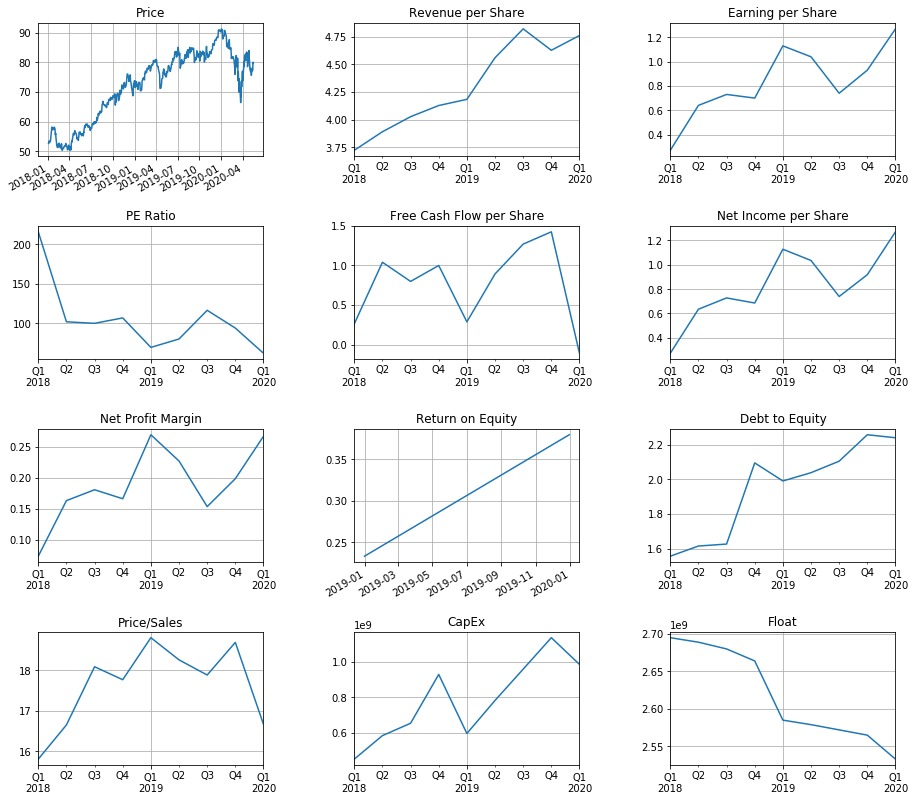

In [223]:
# Plot Key Metrics mini-charts
def PlotKeyMiniCharts(stock, start_date):
    #start_date = '2018-01-01'

    frows, fcols = 4,3
    fig, ax = plt.subplots(frows,fcols, figsize=(14, 14))
    fig.tight_layout(pad=6)

    columns = ["Price", "Revenue per Share","Earning per Share",
               "PE Ratio","Free Cash Flow per Share","Net Income per Share",
               "Net Profit Margin","Return on Equity","Debt to Equity",
               "Price/Sales","CapEx","Float"]
    price_df = sd.GetStockDataFrame(stock)
    keys, column_map, main_df_org = sd.GetFund_Dict(stock)

    tmp_df = pd.DataFrame()

    tmp_df["Revenue per Share"] = main_df_org["income-statement"]["Revenue"]/main_df_org["enterprise-value"]["Number of Shares"]
    tmp_df["Earning per Share"] = main_df_org["income-statement"]["EPS"]
    
    tmp_df["PE Ratio"] = main_df_org["company-key-metrics"]["PE ratio"]
    tmp_df["Free Cash Flow per Share"] = main_df_org["company-key-metrics"]["Free Cash Flow per Share"]
    tmp_df["Net Income per Share"] = main_df_org["company-key-metrics"]["Net Income per Share"]

    tmp_df["CapEx"] = main_df_org["cash-flow-statement"]["Capital Expenditure"]
    tmp_df["Float"] = main_df_org["enterprise-value"]["Number of Shares"]
    tmp_df["Price/Sales"] = main_df_org["company-key-metrics"]["Price to Sales Ratio"]
    
    tmp_df["Return on Equity"] = main_df_org["financial-ratios"]["profitabilityIndicatorRatios_returnOnEquity"]
    tmp_df["Net Profit Margin"] = main_df_org["income-statement"]["Net Profit Margin"]
    tmp_df["Debt to Equity"] = main_df_org["company-key-metrics"]["Debt to Equity"]
 
    #display(sd.key_stat(stock))
    ks_df = sd.key_stat(stock)
    link = "<a target='_blank' href='https://snapshot.fidelity.com/fidresearch/snapshot/landing.jhtml#/research?symbol="+stock.upper()+"&appCode='>"+stock.upper()+"</a>"
    ks_df['symbol'] = link
    display(HTML(ks_df.to_html(escape=False)))
    
    n , m = 0, 0
    for c in columns:
        ax[n,m].set_title(c)
        #ax[0,0].xaxis.set_visible(False)
        #ax[0,0].yaxis.set_visible(False)
        #ax[n,m].xaxis.set_label_text("xccxxx")
        if c == "Price":
            if(start_date != None):
                price_df['AdjClose'] = sd.DatesRange(price_df['AdjClose'], start_date)
            price_df['AdjClose'].plot(ax=ax[n,m])
        else:
            if(start_date != None):
                tmp_df[c] = sd.DatesRange(tmp_df[c], start_date)
                tmp_df[c].dropna(inplace=True)
            tmp_df[c].plot(ax=ax[n,m])
        
        ax[n,m].xaxis.set_label_text("")
        ax[n,m].grid(b=True, which='major', axis='both')
        m = m + 1
        if(m>fcols-1):
            m = 0
            n = n + 1
    return tmp_df

metrics_df = PlotKeyMiniCharts(mystock, start_date='2018-01-01')

In [224]:
# Get stock data and Set range
price_df = sd.GetStockDataFrame(mystock)
price_df = sd.DatesRange(price_df, '2017-08-01') # limit the data since a specific past date or a range

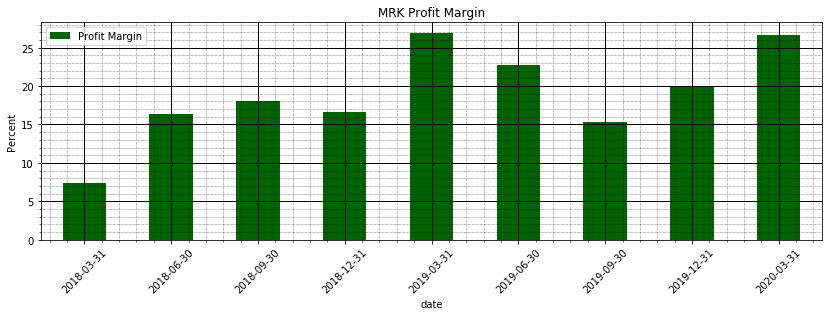

In [225]:
def PlotProfitMargin(stock, start_date):
    import matplotlib.ticker as ticker
    fig, ax = plt.subplots()
    keys, column_map, main_df_org = sd.GetFund_Dict(stock)
    npm_df = sd.MakeFund_Subset(main_df_org['income-statement'],["Profit Margin"])
    npm_df = sd.DatesRange(npm_df, start_date)
    tmp_df = (npm_df * 100)
    tmp_df.plot(ax=ax, kind='bar',figsize=(14,4),
                title=stock.upper()+' Profit Margin',grid=True, 
                color='darkgreen').set_ylabel('Percent')


    ax.xaxis.grid( which = 'minor')
    ax.grid(True)

    _=plt.xticks(rotation=45)

    ax.minorticks_on()
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.xaxis.grid(which='major', linestyle='-', linewidth='1.0', color='black')
    ax.yaxis.grid(which='major', linestyle='-', linewidth='1.0', color='black')

    ticklabels = tmp_df.index.strftime('%Y-%m-%d')
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))

PlotProfitMargin(mystock, start_date="2018-01-01")

In [226]:
# Print range table
rc = ''
rec_columns=['Symbol','Name','Sector','Recommendation','Close','BuyAt','SellAt']
record = defaultdict(list) 
recomm_list = []

s = mystock
sd.set_stock(s)
stock_info = sd.get_stock_info(s)

if not price_df.empty:
    rc, price_df2, low_df, hi_df, action_df = sd.GetBuySellEnvelope(s,price_df, minmax_period)
    if not rc:
        print("Function Failed")
    else:
        rec = action_df['Recommendation'][0]
        #if(action_df['Recommendation'][0] == 'buy'):
        record = {'Symbol':s.upper(),'Name': stock_info['name'][0], 'Sector':stock_info['sector'][0],
                'Recommendation':rec.upper(),'Close':sd.quote(s).close[0],'BuyAt':action_df['BuyAt'][0],
                'SellAt':action_df['SellAt'][0],'Upside $': round( action_df['SellAt'][0] - sd.quote(s).close[0],2),
                'Upside %': str( round( 100 * ((action_df['SellAt'][0] - sd.quote(s).close[0] )/sd.quote(s).close[0] )  ,2) )+'%',
                'Ave. Hold (days)': 0}

        recomm_list.append(record)
        recomm_df = pd.DataFrame(recomm_list)

link = "<a target='_blank' href='https://snapshot.fidelity.com/fidresearch/snapshot/landing.jhtml#/research?symbol="+s.upper()+"&appCode='>"+s.upper()+"</a>"
recomm_df['Symbol'] = link
HTML(recomm_df.to_html(escape=False))

,Symbol,Name,Sector,Recommendation,Close,BuyAt,SellAt,Upside $,Upside %,Ave. Hold (days)
0,MRK,Merck & Co.,Health Care,NO,79.78,77.19,81.18,1.4,1.75%,0


MRK Buy Sell Env. Chart


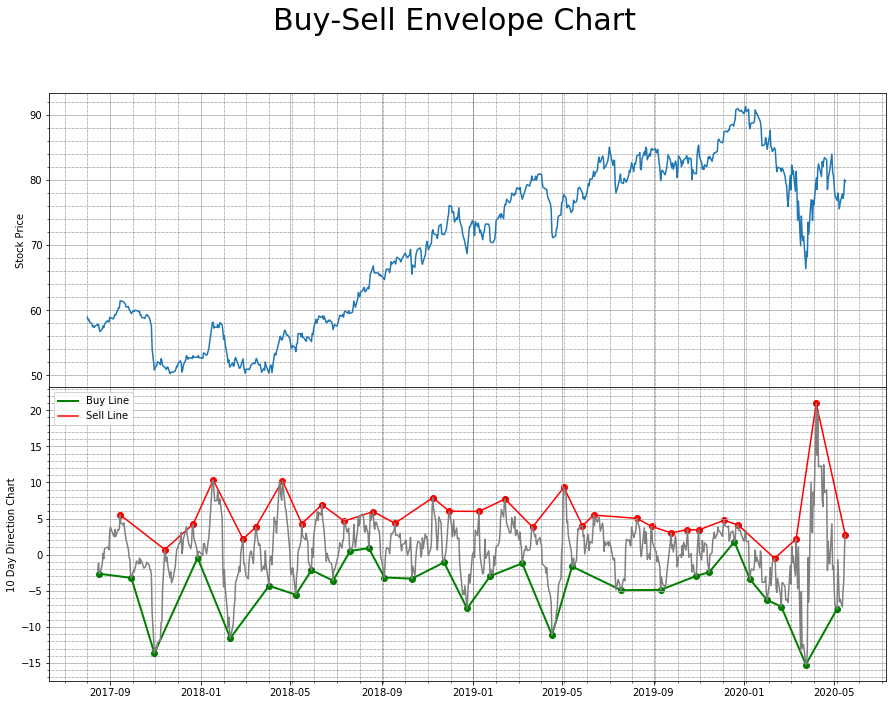

Closed $79.78 on 2020-05-15 13:30:00
Price change range is from  -4.51% to 5.37%
Sell range from  79.78 to 76.19
Last Buy signal on  2020-05-04 13:30:00 Close price was $ 76.86
Last Sell signal on  2020-05-15 13:30:00 Close price was $ 79.78


In [227]:
# Sell-Buy Range
if(not price_df.empty):
    print(mystock.upper()+' Buy Sell Env. Chart')
    price_df3, low_df, hi_df = sd.PlotBuySellEnvelope(price_df, 10)
    
    squote = sd.quote(mystock)
    print('Closed $'+str(squote.close[0]),'on',squote.date[0])
    low_df.dropna(inplace=True)
    hi_df.dropna(inplace=True)

    date_last_buy = low_df.index[-1]
    date_last_sell = hi_df.index[-1]

    price_last_buy = price_df3[price_df3.index == low_df.index[-1]][0]
    price_last_sell = price_df3[price_df3.index == hi_df.index[-1]][0]
 
    ave_min_delta = low_df.mean()
    ave_max_delta = hi_df.mean()
    print("Price change range is from ",str(round(ave_min_delta,2))+"% to", str(round(ave_max_delta,2))+"%")

    if date_last_buy > date_last_sell:
        print("Buy range from ",round( price_last_buy,2), "to", 
              round( price_last_buy + (price_last_buy * ave_max_delta / 100), 2))
    else:
        print("Sell range from ",round( price_last_sell,2), "to", 
              round(price_last_sell + (price_last_sell * ave_min_delta / 100) ,2))

    print("Last Buy signal on ",date_last_buy,"Close price was $",round(price_last_buy,2))
    print("Last Sell signal on ",date_last_sell,"Close price was $",round(price_last_sell,2))

<Figure size 1080x432 with 0 Axes>

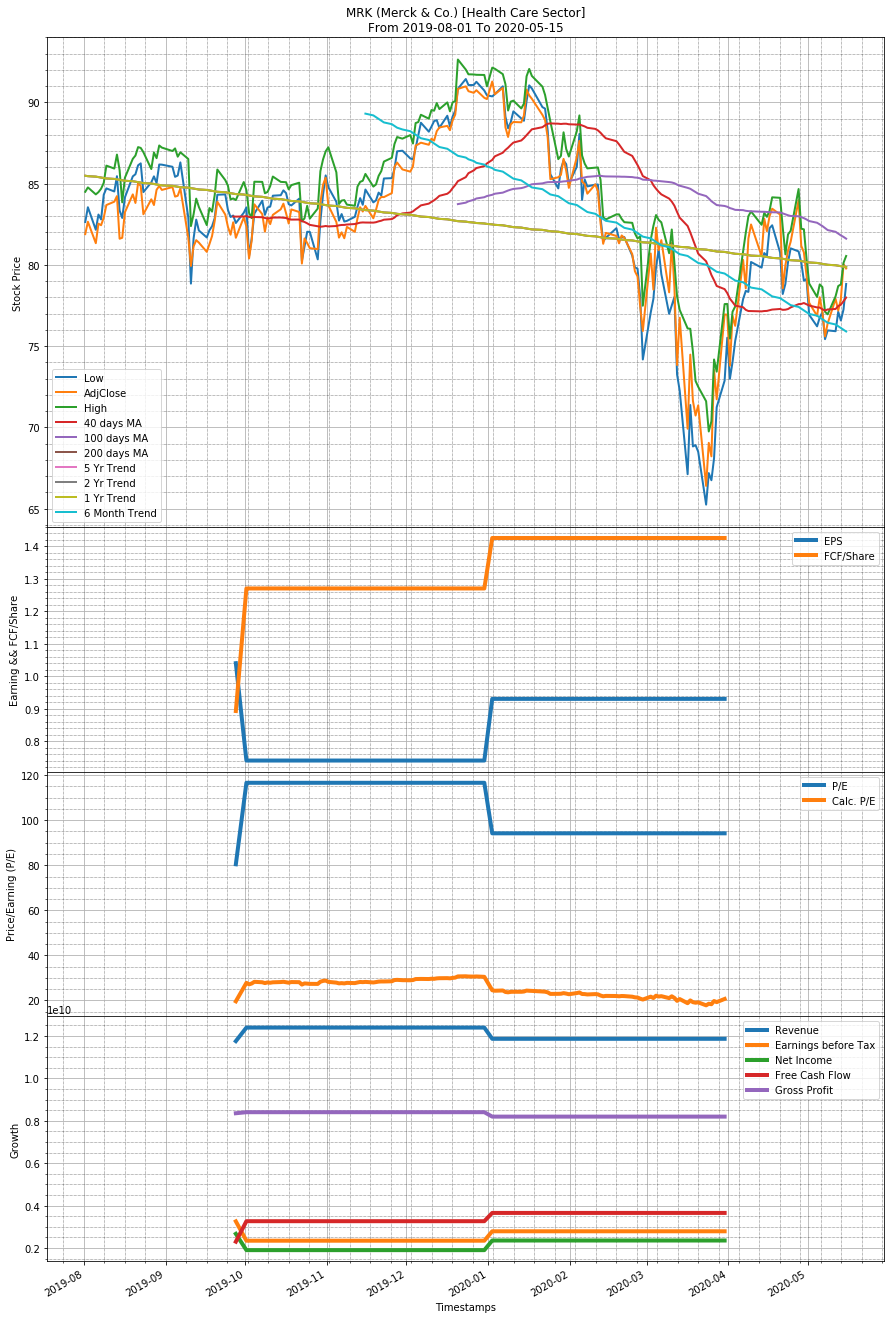

In [228]:
# Plot stock basic charts
price_df = sd.GetStockDataFrame(mystock)
if(not price_df.empty):
    price_df = sd.DatesRange(price_df, '2019-08-01') # limit the data since a specific past date or a range

    linear_trends = sd.PlotBasicCharts(mystock,price_df)
    plt.show()

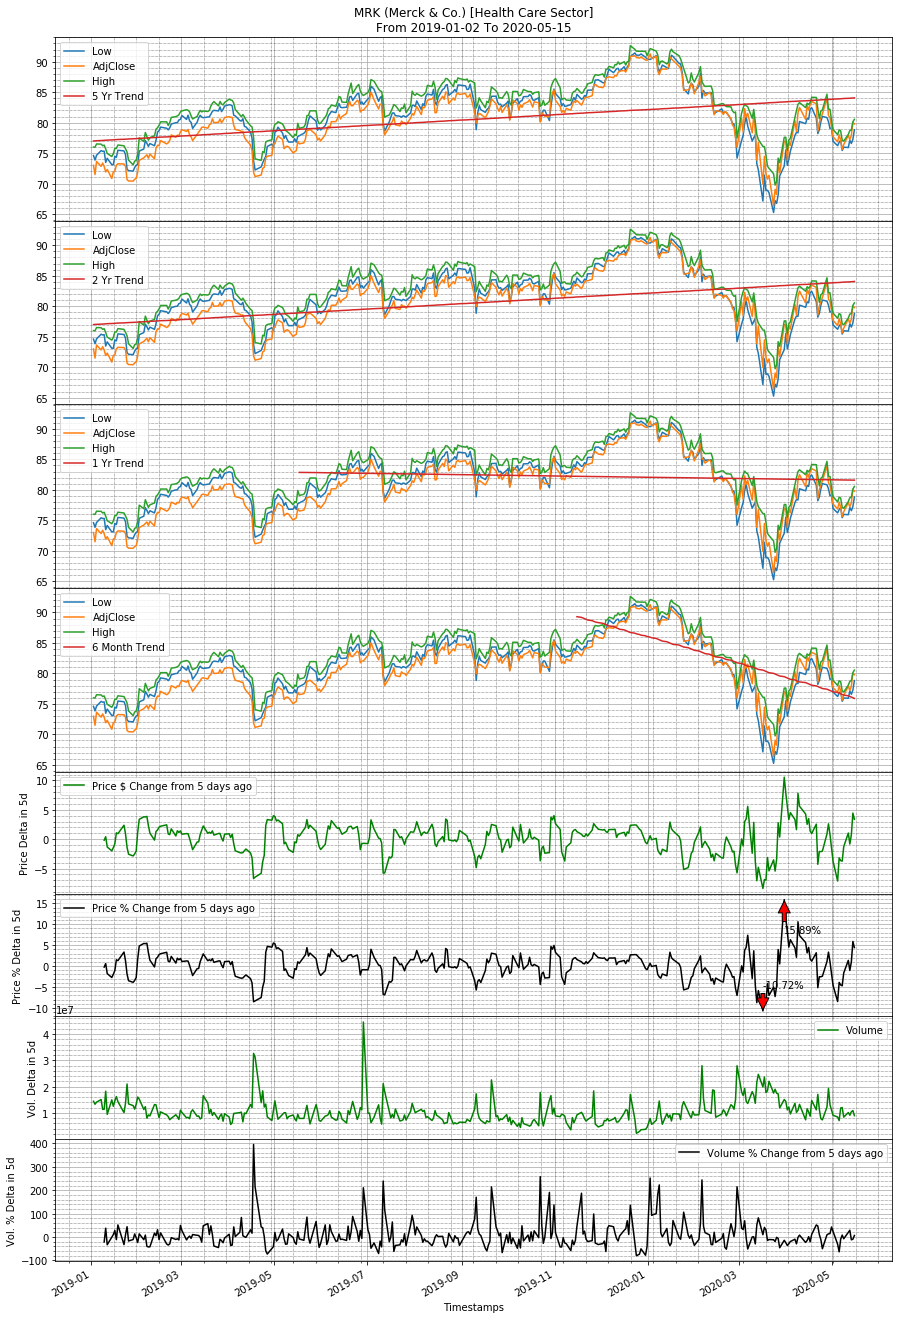

In [229]:
price_df = sd.GetStockDataFrame(mystock)
if(not price_df.empty):
    price_df = sd.DatesRange(price_df, '2019-01-01')
    price_data_df, maximums_table_df, trends = sd.PlotTrends(mystock,price_df)

In [230]:
if(not price_df.empty):
    for k,v in trends.items():
        print(k,round(v[1],4))

5y Trend 0.0205
2y Trend 0.0205
1y Trend -0.0051
6m Trend -0.1081


In [231]:
if(not price_df.empty):
    maximums_table_df

MRK


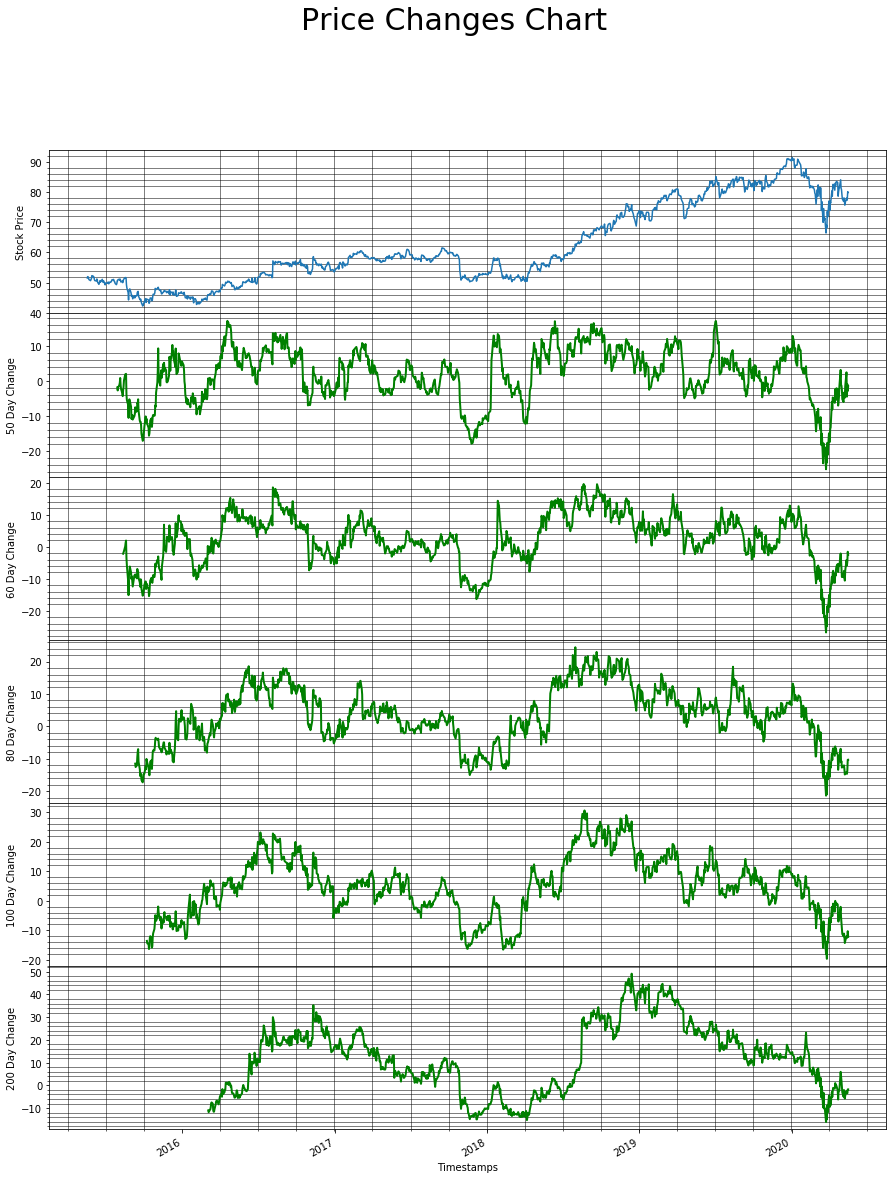

In [232]:
# Set the stock and get the prices dataframe
print(mystock)
price_df = sd.GetStockDataFrame(mystock)
if(not price_df.empty):
    # You can limit the range if needed
    #price_df = sd.DatesRange(price_df, '2016-02-01')
   
    sd.PlotPriceChangesPercent(price_df,[50,60,80,100,200])

MRK


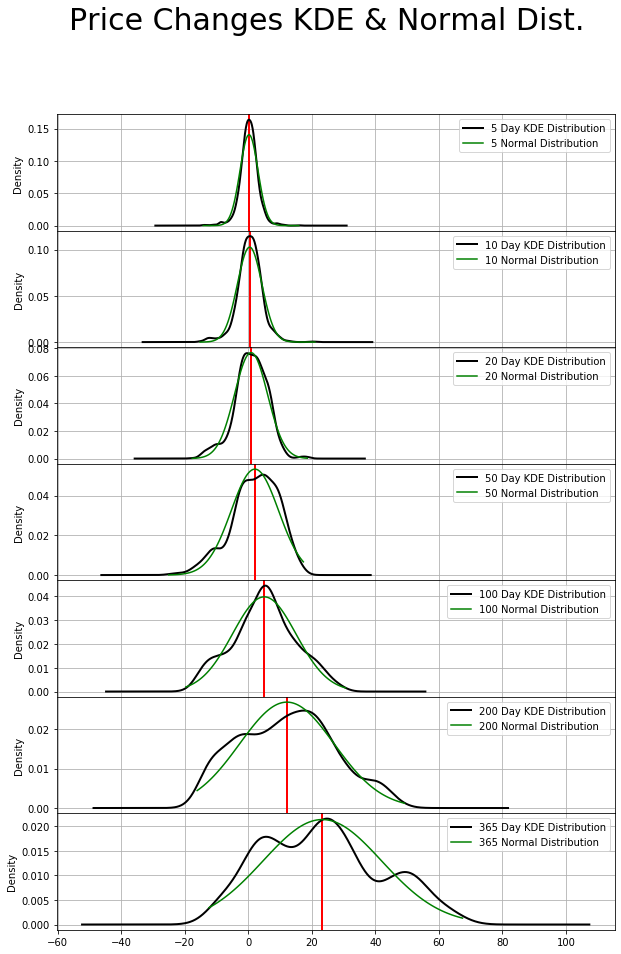

In [233]:
# Set the stock and get the prices dataframe
print(mystock)
price_df = sd.GetStockDataFrame(mystock)
if(not price_df.empty):
    price_changes, stats = sd.PlotPriceChangesKDE(price_df,[5,10,20,50,100,200,365])
    stats